# 2章：テキスト分類

In [1]:
from datasets import list_datasets

all_datasets = list_datasets()
print(all_datasets[:10])

['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [2]:
from datasets import load_dataset

emotions = load_dataset("emotion")
emotions["train"]

Using custom data configuration default
Reusing dataset emotion (/home/hattori-k/.cache/huggingface/datasets/emotion/default/0.0.0/aa34462255cd487d04be8387a2d572588f6ceee23f784f37365aa714afeb8fe6)


Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [3]:
import pandas as pd

def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

emotions.set_format(type="pandas")
df = emotions["train"][:]
df["label_name"] = df["label"].apply(label_int2str)
df.head()

,label,text,label_name
0,0,i didnt feel humiliated,sadness
1,0,i can go from feeling so hopeless to so damned...,sadness
2,3,im grabbing a minute to post i feel greedy wrong,anger
3,2,i am ever feeling nostalgic about the fireplac...,love
4,3,i am feeling grouchy,anger


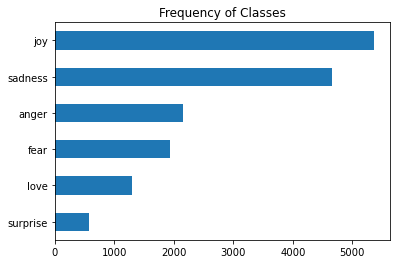

In [4]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

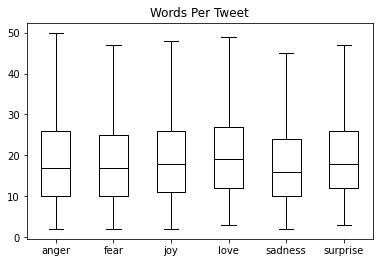

In [5]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [6]:
emotions.reset_format()

In [7]:
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18, 'z': 19}


In [8]:
categorical_df = pd.DataFrame(
    {"Name": ["Bumblebee", "Optimus Prime", "Megatron"], "Label ID": [0, 1, 2]}
)
categorical_df

,Name,Label ID
0,Bumblebee,0
1,Optimus Prime,1
2,Megatron,2


In [9]:
pd.get_dummies(categorical_df["Name"])

,Bumblebee,Megatron,Optimus Prime
0,1,0,0
1,0,0,1
2,0,1,0


In [10]:
import torch
import torch.nn.functional as F

input_ids = torch.tensor([token2idx[token] for token in tokenized_text])
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encodings.shape

torch.Size([38, 20])

In [11]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

vocab_file vocab.txt
tokenizer_file tokenizer.json
added_tokens_file added_tokens.json
special_tokens_map_file special_tokens_map.json
tokenizer_config_file tokenizer_config.json


In [12]:
# 特定のクラスを手動でロードする場合
from transformers import DistilBertTokenizer

distlibert_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

vocab_file vocab.txt
added_tokens_file added_tokens.json
special_tokens_map_file special_tokens_map.json
tokenizer_config_file tokenizer_config.json


In [13]:
encoded_text = tokenizer(text)
encoded_text #単語がinput_idフィールドで一意な整数にマッピングされている

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [14]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens) # "##"は「直前の文字列が空白でない」という意味

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


In [15]:
tokenizer.convert_tokens_to_string(tokens)

'[CLS] tokenizing text is a core task of nlp. [SEP]'

In [16]:
tokenizer.vocab_size, tokenizer.model_max_length, tokenizer.model_input_names

(30522, 512, ['input_ids', 'attention_mask'])

In [17]:
# 事例のバッチに対してtokenizerを適用する関数
    # padding=True：バッチ内で最大長のサイズまで埋める
    # truncation=True：モデルの最大コンテキストサイズまで埋める
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

emotions["train"][:2], tokenize(emotions["train"][:2]) # パディング部分はattention_maskが0になっていることがわかる

({'label': [0, 0],
  'text': ['i didnt feel humiliated',
   'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake']},
 {'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]})

In [23]:
# デフォルトではtokenizeは個別に動作するが、batched=True, batch_size=Noneとしているので、全体を1つのバッチとして適用
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)
emotions_encoded["train"]

Loading cached processed dataset at /home/hattori-k/.cache/huggingface/datasets/emotion/default/0.0.0/aa34462255cd487d04be8387a2d572588f6ceee23f784f37365aa714afeb8fe6/cache-dc8da2abbb5d8fbf.arrow
Loading cached processed dataset at /home/hattori-k/.cache/huggingface/datasets/emotion/default/0.0.0/aa34462255cd487d04be8387a2d572588f6ceee23f784f37365aa714afeb8fe6/cache-2fa9b08591648854.arrow
Loading cached processed dataset at /home/hattori-k/.cache/huggingface/datasets/emotion/default/0.0.0/aa34462255cd487d04be8387a2d572588f6ceee23f784f37365aa714afeb8fe6/cache-12a38d2cd28d2a7b.arrow


Dataset({
    features: ['attention_mask', 'input_ids', 'label', 'text'],
    num_rows: 16000
})

## テキスト分類器の学習

In [19]:
from transformers import AutoModel
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)
device

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


device(type='cuda', index=0)

In [20]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt") # return_tensors="pt"でPyTorchのテンソルに変換
inputs

{'input_ids': tensor([[ 101, 2023, 2003, 1037, 3231,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}

In [21]:
inputs = {k: v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
outputs, outputs.last_hidden_state.size() # 最後の隠れ状態抽出

(BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
          [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
          [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
          [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
          [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
          [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
        device='cuda:0'), hidden_states=None, attentions=None),
 torch.Size([1, 6, 768]))

#### Transformersを特徴量ベースで使う (重みを学習しない)

In [27]:
def extract_hidden_states(batch):
    inputs = {k: v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)
emotions_hidden["train"].column_names

['attention_mask', 'hidden_state', 'input_ids', 'label', 'text']

In [28]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

In [29]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.6335

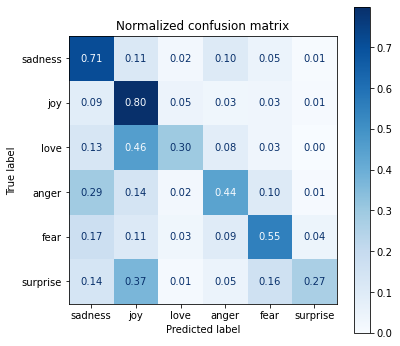

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax)
    plt.title("Normalized confusion matrix")
    plt.show()

labels = emotions["train"].features["label"].names
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

#### Transformerをファインチューニングして使う

In [33]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=6).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classi

In [47]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [ ]:
# Hugging Face Hubにログイン
from huggingface_hub import notebook_login

notebook_login()

In [44]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"distilbert-base-uncased-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True, 
                                  log_level="error")

In [ ]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args, compute_metrics=compute_metrics, train_dataset=emotions_encoded["train"], eval_dataset=emotions_encoded["validation"], tokenizer=tokenizer)
trainer.train()

In [49]:
preds_output = trainer.predict(emotions_encoded["validation"])
preds_output.metrics

/home/hattori-k/.conda/envs/pytorch/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'test_loss': 0.20638048648834229,
 'test_accuracy': 0.922,
 'test_f1': 0.9225903813139017,
 'test_runtime': 2.6039,
 'test_samples_per_second': 768.076,
 'test_steps_per_second': 6.145}

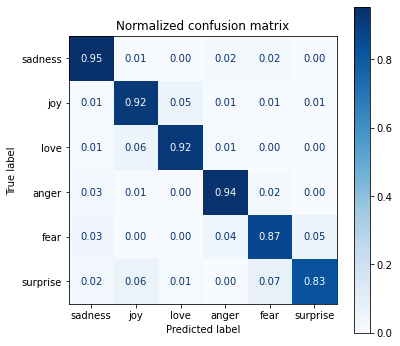

In [50]:
y_preds = np.argmax(preds_output.predictions, axis=1)
plot_confusion_matrix(y_preds, y_valid, labels)

In [51]:
trainer.push_to_hub(commit_message="『機械学習エンジニアのためのTransformers』2章")

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/aya-se/distilbert-base-uncased-finetuned-emotion
   ae145f0..32f6e2e  main -> main



To https://huggingface.co/aya-se/distilbert-base-uncased-finetuned-emotion
   32f6e2e..b769bc4  main -> main



'https://huggingface.co/aya-se/distilbert-base-uncased-finetuned-emotion/commit/32f6e2ed06fc6939fa042ae1f0bd4a5171298e18'

In [53]:
# pipelineで実行する
from transformers import pipeline

classifier = pipeline("text-classification", model="aya-se/distilbert-base-uncased-finetuned-emotion")
custom_tweet = "I saw a movie today and it was really good."
preds = classifier(custom_tweet, return_all_scores=True)
preds

vocab_file vocab.txt
tokenizer_file tokenizer.json
added_tokens_file added_tokens.json
special_tokens_map_file special_tokens_map.json
tokenizer_config_file tokenizer_config.json


[[{'label': 'LABEL_0', 'score': 0.010583418421447277},
  {'label': 'LABEL_1', 'score': 0.9748144745826721},
  {'label': 'LABEL_2', 'score': 0.005628346465528011},
  {'label': 'LABEL_3', 'score': 0.002999061020091176},
  {'label': 'LABEL_4', 'score': 0.0025319461710751057},
  {'label': 'LABEL_5', 'score': 0.0034427072387188673}]]